<a href="https://colab.research.google.com/github/harperd/machine-learning/blob/master/notebooks/simple-linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Linear Regression

Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities. You need to figure out what the expected profit of a new food truck might be given only the population of the city that it would be placed in.

In [0]:
# NumPy adds support for large, multi-dimensional arrays and matrices, along with a large collection 
# of high-level mathematical functions to operate on these arrays.
import numpy as np

# Matplotlib is a plotting library for the Python programming language and its numerical mathematics 
# extension NumPy. It provides an object-oriented API for embedding plots into applications using 
# general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK+.
import matplotlib.pyplot as plt

# Allow saving our graphs in the notebook
%matplotlib inline

# Pandas is a software library for data manipulation and analysis. In particular, it offers data 
# structures and operations for manipulating numerical tables and time series.
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D

In [2]:
df_raw = pd.read_csv(
    'https://raw.githubusercontent.com/harperd/machine-learning/master/data/ex1data1.csv',
    header = None,
    names=[ 'Population', 'Profit' ])
%time print(f'{len(df_raw.index):,} rows read.')

97 rows read.
CPU times: user 111 µs, sys: 23 µs, total: 134 µs
Wall time: 139 µs


In [3]:
df_raw.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [4]:
df_raw.describe()

,Population,Profit
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


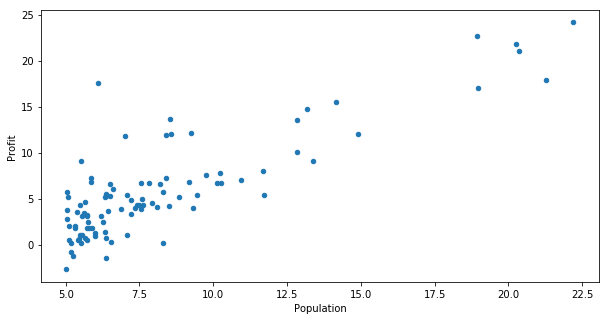

In [5]:
df_raw.plot(kind = 'scatter', x = 'Population', y = 'Profit', figsize = (10, 5))

In [6]:
# Append a bias column to the beginning
# of the DataFrame. This will be used when computing
# the hypothesis using matrix multiplication.
if 'Bias' not in df_raw:
  # Insert new column at index 0, with name Bias and
  # a value of all ones.
  df_raw.insert(0, 'Bias', 1)
  
df_raw.head()

,Bias,Population,Profit
0,1,6.1101,17.5920
1,1,5.5277,9.1302
2,1,8.5186,13.6620
3,1,7.0032,11.8540
4,1,5.8598,6.8233


In [7]:
# Set X (independent/training variable) 
# and y (dependent/target variable)
cols = df_raw.shape[1]

# Get all rows and the first two columns of our DataFrame and assign to X.
X = df_raw.iloc[:, 0:cols - 1]

# Get the last column of our DataFrame and assign to y.
y = df_raw.iloc[:, cols - 1:cols]

# Convert from DataFrames to numpy matrices for easier
# calculations.
X = np.matrix(X.values)
y = np.matrix(y.values)
theta = np.matrix(np.array([ 0, 0 ]))

X.shape, theta.shape, y.shape

((97, 2), (1, 2), (97, 1))

In [0]:
 def compute_cost(X, y, theta):
  # h(x)
  # Calculate predictions, h(x), with current theta values.
  # Here we are doing matrix multiplication as 
  # X multiplied by theta transposed.
  predictions = X * theta.T

  # h(x) - y
  # Get the error which tells us how far off our
  # preditions are from the dependent variables.
  error = predictions - y
  
  # sum( (h(x) - y)^2 )
  # Get the sum square error.
  sum_square_error = np.sum(np.square(error))
  
  # 1/2m * sum( (h(x) - y)^2 )
  # Compute the cost.
  m = len(y)
  cost = sum_square_error / ( 2 * m )
  
  return cost

In [9]:
def gradient_descent(X, y, theta, alpha, iter = None):
    m = y.shape[0]
    cost_history = []
    theta_history = []
    cost = 0
    iterations = 0
    converged = False
    
    # Keep calculating new theta values until we have converged
    # at the minimum.
    while not converged:
      # Calculate predictions, h(x), with current theta values.
      predictions = X * theta.T
      
      # Get the error which tells us how far off we are from the
      # actual/dependent variables.
      error = predictions - y
      
      # Calculate the gradient
      gradient = ( error.T * X ) / m 
      
      # Get our new theta values
      theta = theta - alpha * gradient
      
      # Compute the cost: J(theta0, theta1)
      cost = compute_cost(X, y, theta)

      # Check for convergence.
      # If the previous cost is the same as the current cost then
      # we have converged to the minimum.
      if ((iter != None and iter == iterations) or 
          (iterations > 0 and cost_history[-1] == cost)):
        converged = True
      else:
        # Increase the number of iterations
        iterations = iterations + 1
        # Track our cost history. We will graph this to see how cost
        # decreases with the number of iterations.
        cost_history.append(cost)
        theta_history.append([theta[-1, 0], theta[-1, 1]])
      
    return theta_history, cost_history, iterations
  
thetas, costs, iterations = gradient_descent(X, y, theta, alpha = .01, iter = None)

print(f'Optimal theta values..: {thetas[-1][0]} and {thetas[-1][1]}')
print(f'Minimum Cost..........: {costs[-1]}')
print(f'Iterations............: {iterations:,}')

Optimal theta values..: -3.895778583972698 and 1.1930334136983392
Minimum Cost..........: 4.4769713759756575
Iterations............: 7,962


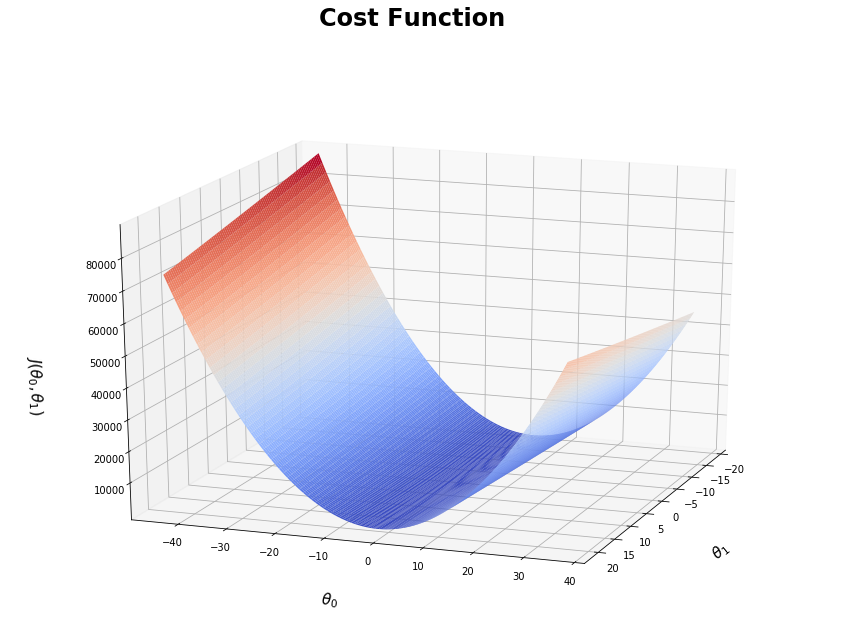

In [10]:
def plot_cost_function(X, costs, thetas):
  theta = thetas[-1]
  xaug = np.array(X)
  history=thetas

  theta = history[-1]

  # Numpy linespace returns evenly spaced numbers over a specified interval.
  ms = np.linspace(theta[1] - 20, theta[1] + 20, 100)
  bs = np.linspace(theta[0] - 40, theta[0] + 40, 100)

  # Numpy meshgrid returns coordinate matrices from coordinate vectors.
  # We want to create create a rectangular array of ms and bs values.
  M, B = np.meshgrid(ms, bs)

  # Numpy ravel returns a contiguous flattened 1-D array, containing the elements
  # of the input, is returned.
  zs = np.array([
    compute_cost(xaug, y, np.matrix(theta)) for theta in zip(np.ravel(M), np.ravel(B))
  ])

  Z = zs.reshape(M.shape)

  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(111, projection='3d')

  # Plot our 3D surface
  surf = ax.plot_surface(M, B, Z, rstride=1, cstride=1, cmap='coolwarm')
  ax.set_xlabel(r'$\theta_1$', labelpad=30, fontsize=15, fontweight='bold')
  ax.set_ylabel(r'$\theta_0$', labelpad=30, fontsize=15, fontweight='bold')
  ax.set_zlabel(r'$J(\theta_0,\theta_1)$', labelpad=30, fontsize=15, fontweight='bold')
  ax.view_init(elev=20, azim=20)

  fig.suptitle('Cost Function', fontsize=24, fontweight='bold')
  
plot_cost_function(X, costs, thetas)

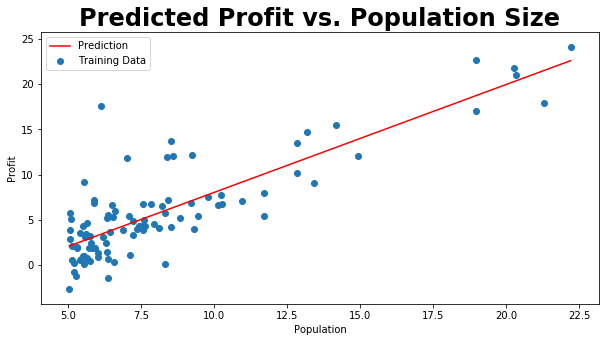

In [11]:
def plot_prediction(thetas, df):
  theta = thetas[-1]
  x = np.linspace(df.Population.min(), df.Population.max(), 100)
  f = theta[0] + (theta[1] * x)

  fig, ax = plt.subplots(figsize = (10,5))

  ax.plot(x, f, 'r', label='Prediction')
  ax.scatter(df.Population, df.Profit, label='Training Data')
  ax.legend(loc = 2)
  ax.set_xlabel('Population')
  ax.set_ylabel('Profit')
  ax.set_title('Predicted Profit vs. Population Size', fontsize=24, fontweight='bold')
  
plot_prediction(thetas, df_raw)

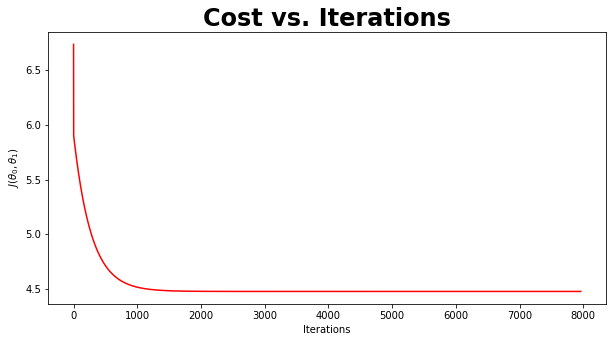

In [12]:
def plot_cost(cost_history):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(cost_history, 'r')
  ax.set_xlabel('Iterations')
  ax.set_ylabel(r'$J(\theta_0,\theta_1)$')
  ax.set_title('Cost vs. Iterations', fontsize=24, fontweight='bold')
  
plot_cost(costs)

In [13]:
def predict(population, theta): 
  scale = 10000
  x = np.array([1, population / scale])
  prediction = np.dot(np.array(theta).transpose(), x)
  return int(round(prediction * scale, 0))

def make_prediction(population, theta):
  prediction = predict(population, theta)
  print(f'For population = {population:,}, we predict a profit of ${prediction:,}.')
        
make_prediction(35000, thetas[-1])
make_prediction(70000, thetas[-1])

For population = 35,000, we predict a profit of $2,798.
For population = 70,000, we predict a profit of $44,555.
